# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from torch.utils.data import SequentialSampler

!pip install torchmetrics
!pip install --upgrade torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 22.0 MB/s eta 0:00:00


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda') # GPU
else:
  device = torch.device('cpu') # CPU

print(device)
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

cpu
Using 0 GPUs
CUDA is available: False


In [ ]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    t_Labels = []
    t_Preds = []

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        t_Labels.extend(labels)
        t_Preds.extend(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time, t_Preds, t_Labels

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    v_Labels = []
    v_Preds = []

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

            v_Labels.extend(labels)
            v_Preds.extend(predicts)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc, v_Preds, v_Labels

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        state_dict = torch.load(model_path, weights_only=True) # Prevent risks with untrusted pickle data.
        model.load_state_dict(state_dict)
        #model.load_state_dict(torch.load(model_path)) # TA's code
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    e_Labels = []
    e_Preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

            e_Labels.extend(labels)
            e_Preds.extend(predicts)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc, e_Preds, e_Labels

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# define folder path for each set
train_path = '/content/drive/MyDrive/HW3_dataset/train'
test_path = '/content/drive/MyDrive/HW3_dataset/test'
val_path = '/content/drive/MyDrive/HW3_dataset/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
sampler_tr = SequentialSampler(train_dataset) # To make sure to more control over the dataloaders order
sampler_va = SequentialSampler(val_dataset) # To make sure to more control over the dataloaders order
sampler_te = SequentialSampler(test_dataset) # To make sure to more control over the dataloaders order
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_tr, shuffle=False) # TA's code shuffle=True
val_loader = DataLoader(val_dataset, batch_size=64, sampler=sampler_va, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, sampler=sampler_te, shuffle=False)

In [ ]:
# Overview dataset
def analyze_dataset(dataloader):
  all_labels = []
  all_shapes = []
  for images, labels in dataloader:
    all_labels.extend(labels.tolist())
    for image in images:
      all_shapes.append(image.shape)

  label_counts = pd.Series(all_labels).value_counts()
  unique_shapes = set(all_shapes)

  return {
      "Number of Images": len(all_labels),
      "Number of Labels (Classes)": len(label_counts),
      "Label Counts": label_counts.to_dict(),
      "Unique Shapes": unique_shapes,
  }

train_stats = analyze_dataset(train_loader)
test_stats = analyze_dataset(test_loader)
val_stats = analyze_dataset(val_loader)

# Print the statistics for each dataset
print("Train Dataset Statistics:")
for key, value in train_stats.items():
  print(f"{key}: {value}")
print("\n")

print("Test Dataset Statistics:")
for key, value in test_stats.items():
  print(f"{key}: {value}")
print("\n")

print("Validation Dataset Statistics:")
for key, value in val_stats.items():
  print(f"{key}: {value}")

Train Dataset Statistics:
Number of Images: 2000
Number of Labels (Classes): 2
Label Counts: {0: 1000, 1: 1000}
Unique Shapes: {torch.Size([1, 256, 256])}


Test Dataset Statistics:
Number of Images: 624
Number of Labels (Classes): 2
Label Counts: {1: 390, 0: 234}
Unique Shapes: {torch.Size([1, 256, 256])}


Validation Dataset Statistics:
Number of Images: 16
Number of Labels (Classes): 2
Label Counts: {0: 8, 1: 8}
Unique Shapes: {torch.Size([1, 256, 256])}


In [ ]:
# Examine classes
print("Train Dataset Labels:", train_dataset.classes)
print("Test Dataset Labels:", test_dataset.classes)
print("Validation Dataset Labels:", val_dataset.classes)

Train Dataset Labels: ['NORMAL', 'PNEUMONIA']
Test Dataset Labels: ['NORMAL', 'PNEUMONIA']
Validation Dataset Labels: ['NORMAL', 'PNEUMONIA']


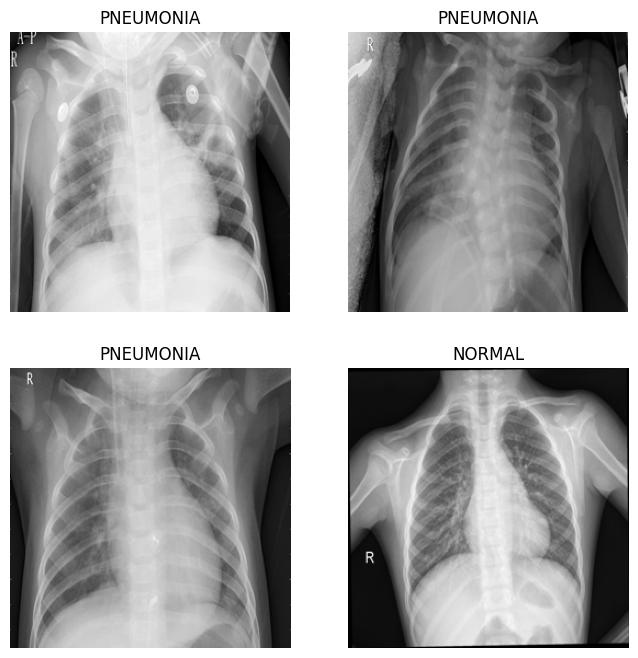

In [ ]:
# Examine image quality
labels_map = {
    0: train_dataset.classes[0],
    1: train_dataset.classes[1],
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

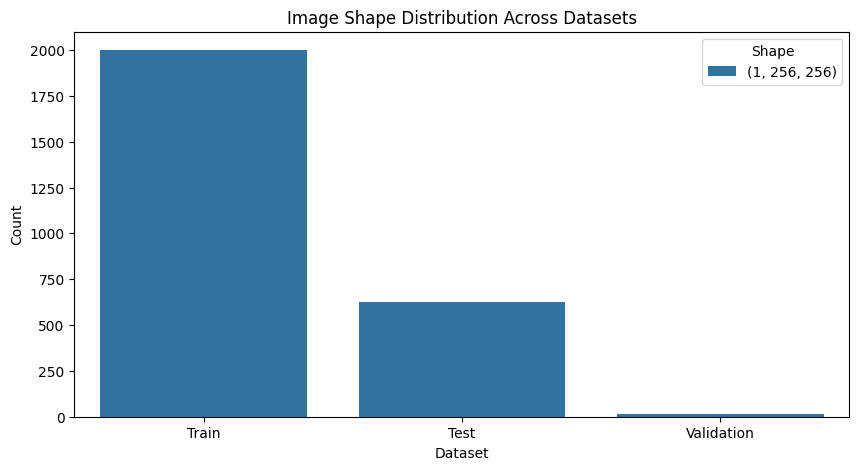

In [ ]:
# Examine image shape
def get_image_shapes(dataloader):
  shapes = defaultdict(int)
  for images, labels in dataloader:
    for image in images:
      shape = tuple(image.shape)
      shapes[shape] += 1
  return shapes

train_shapes = get_image_shapes(train_loader)
test_shapes = get_image_shapes(test_loader)
val_shapes = get_image_shapes(val_loader)

# Combine the data for plotting
data = {
    'Dataset': ['Train'] * len(train_shapes) + ['Test'] * len(test_shapes) + ['Validation'] * len(val_shapes),
    'Shape': list(train_shapes.keys()) + list(test_shapes.keys()) + list(val_shapes.keys()),
    'Count': list(train_shapes.values()) + list(test_shapes.values()) + list(val_shapes.values())
}
df = pd.DataFrame(data)

# Convert shapes to strings for plotting
df['Shape'] = df['Shape'].astype(str)

# Create the plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Dataset', y='Count', hue='Shape', data=df)
plt.title('Image Shape Distribution Across Datasets')
plt.show()

# Model

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #nn.Dropout(0.5), # TA defult with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #nn.Dropout(0.5), # TA defult with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #nn.Dropout(0.5), # TA defult with dropout p=0.5

    nn.Linear(64, 1),
    nn.Sigmoid()
)

model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=64, bias=True)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=1, bias=True)
  (11): Sigmoid()
)


# Loop

In [ ]:
doe02 = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/HW3_dataset/HW3_DOE_02.CSV'))
doe02.head()

,StdOrder,RunOrder,CenterPt,Blocks,lr,weight_decay,factor,criterion
0,8,1,1,1,0.0010,0.0010,0.10,nn.MSELoss()
1,2,2,1,1,0.0010,0.0001,0.01,nn.MSELoss()
2,16,3,1,1,0.0010,0.0010,0.10,nn.BCELoss()
3,6,4,1,1,0.0010,0.0001,0.10,nn.MSELoss()
4,13,5,1,1,0.0001,0.0001,0.10,nn.BCELoss()


In [ ]:
# define the weight_init function and make sure the same weights every time
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)  # Set the seed for CPU
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)  # Set the seed for CUDA
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

DOE RunOrder 1 Epoch 1/10 - loss: 0.3001 - train_acc: 42.29% - val_loss: 0.2679 - val_acc: 56.25% - time: 80.21s
DOE RunOrder 1 Epoch 2/10 - loss: 0.2452 - train_acc: 60.35% - val_loss: 0.2923 - val_acc: 37.50% - time: 82.00s
DOE RunOrder 1 Epoch 3/10 - loss: 0.2207 - train_acc: 71.92% - val_loss: 0.3538 - val_acc: 43.75% - time: 80.27s
DOE RunOrder 1 Epoch 4/10 - loss: 0.2183 - train_acc: 71.97% - val_loss: 0.3647 - val_acc: 43.75% - time: 82.37s
DOE RunOrder 1 Epoch 5/10 - loss: 0.2256 - train_acc: 68.02% - val_loss: 0.3496 - val_acc: 43.75% - time: 81.04s
DOE RunOrder 1 Epoch 6/10 - loss: 0.1802 - train_acc: 84.13% - val_loss: 0.2670 - val_acc: 50.00% - time: 85.06s
DOE RunOrder 1 Epoch 7/10 - loss: 0.1575 - train_acc: 92.19% - val_loss: 0.2610 - val_acc: 50.00% - time: 80.54s
DOE RunOrder 1 Epoch 8/10 - loss: 0.1459 - train_acc: 94.48% - val_loss: 0.2585 - val_acc: 50.00% - time: 81.55s
DOE RunOrder 1 Epoch 9/10 - loss: 0.1378 - train_acc: 95.21% - val_loss: 0.2569 - val_acc: 50.00

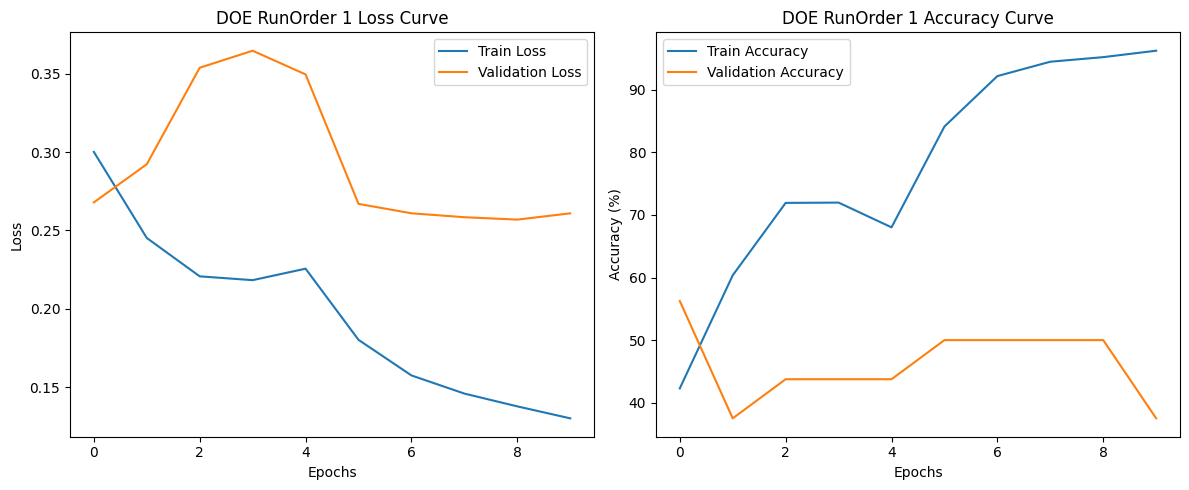

Model weights loaded successfully.
Test Accuracy: 51.98%
Test Loss: 0.2616


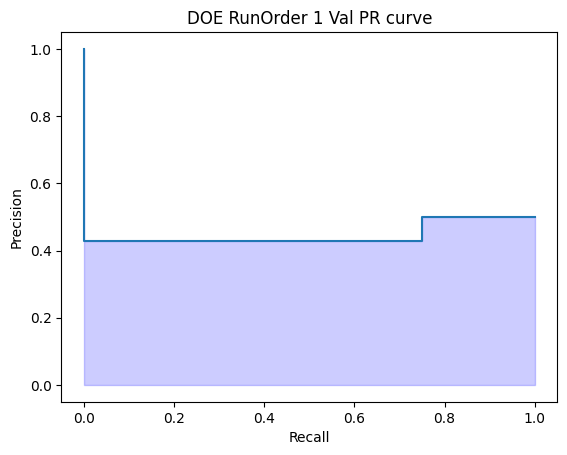

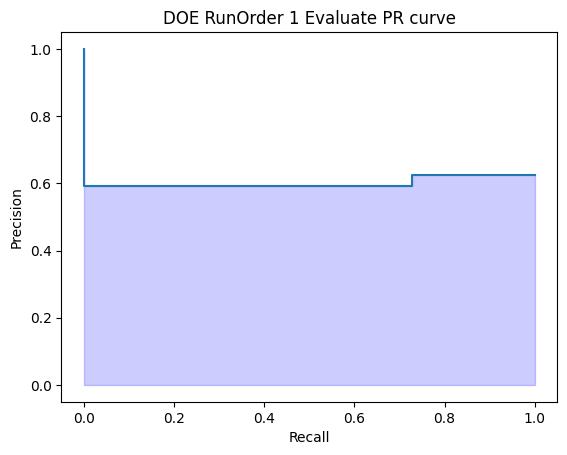

DOE RunOrder 2 Epoch 1/10 - loss: 0.2962 - train_acc: 43.85% - val_loss: 0.2305 - val_acc: 62.50% - time: 80.95s
DOE RunOrder 2 Epoch 2/10 - loss: 0.2512 - train_acc: 57.08% - val_loss: 0.2873 - val_acc: 37.50% - time: 82.18s
DOE RunOrder 2 Epoch 3/10 - loss: 0.2292 - train_acc: 69.24% - val_loss: 0.2017 - val_acc: 68.75% - time: 83.97s
DOE RunOrder 2 Epoch 4/10 - loss: 0.2110 - train_acc: 77.15% - val_loss: 0.3136 - val_acc: 43.75% - time: 81.48s
DOE RunOrder 2 Epoch 5/10 - loss: 0.1917 - train_acc: 82.57% - val_loss: 0.3458 - val_acc: 56.25% - time: 80.32s
DOE RunOrder 2 Epoch 6/10 - loss: 0.1686 - train_acc: 87.30% - val_loss: 0.4039 - val_acc: 50.00% - time: 83.50s
DOE RunOrder 2 Epoch 7/10 - loss: 0.1513 - train_acc: 89.65% - val_loss: 0.3542 - val_acc: 43.75% - time: 82.29s
DOE RunOrder 2 Epoch 8/10 - loss: 0.1593 - train_acc: 85.45% - val_loss: 0.2366 - val_acc: 68.75% - time: 81.17s
DOE RunOrder 2 Epoch 9/10 - loss: 0.1500 - train_acc: 88.48% - val_loss: 0.2324 - val_acc: 75.00

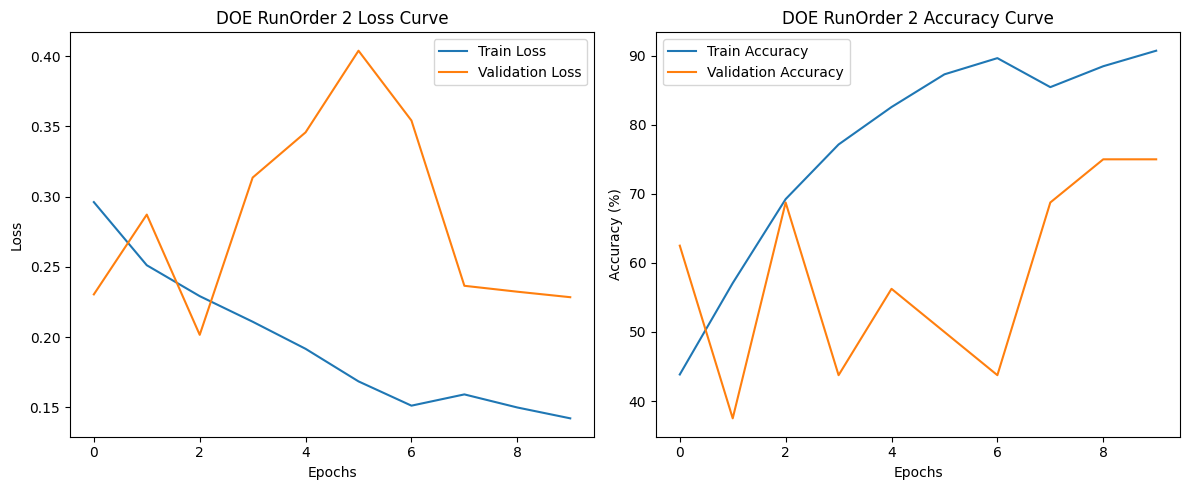

Model weights loaded successfully.
Test Accuracy: 65.31%
Test Loss: 0.2460


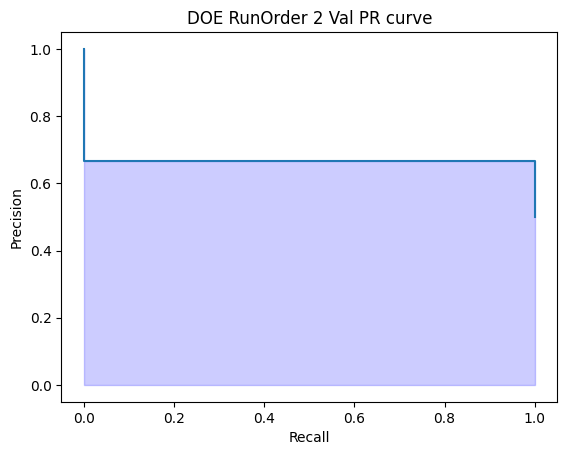

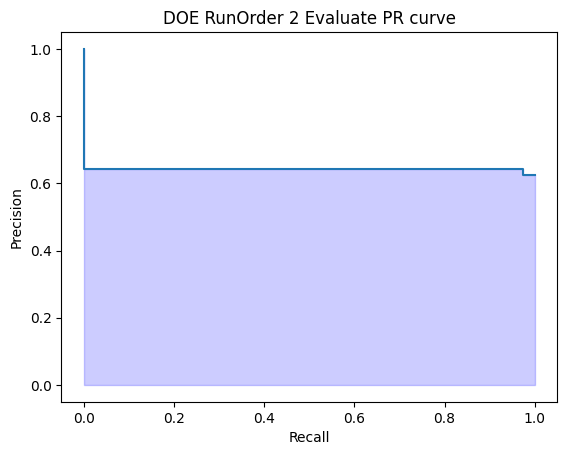

DOE RunOrder 3 Epoch 1/10 - loss: 0.7957 - train_acc: 38.67% - val_loss: 0.9942 - val_acc: 50.00% - time: 81.66s
DOE RunOrder 3 Epoch 2/10 - loss: 0.6904 - train_acc: 55.03% - val_loss: 0.7934 - val_acc: 37.50% - time: 79.84s
DOE RunOrder 3 Epoch 3/10 - loss: 0.6579 - train_acc: 64.84% - val_loss: 0.7217 - val_acc: 56.25% - time: 81.71s
DOE RunOrder 3 Epoch 4/10 - loss: 0.6306 - train_acc: 72.22% - val_loss: 0.6842 - val_acc: 56.25% - time: 80.35s
DOE RunOrder 3 Epoch 5/10 - loss: 0.6129 - train_acc: 75.29% - val_loss: 1.0458 - val_acc: 43.75% - time: 81.50s
DOE RunOrder 3 Epoch 6/10 - loss: 0.5900 - train_acc: 79.25% - val_loss: 1.0571 - val_acc: 50.00% - time: 80.12s
DOE RunOrder 3 Epoch 7/10 - loss: 0.5726 - train_acc: 81.25% - val_loss: 0.8565 - val_acc: 43.75% - time: 81.30s
DOE RunOrder 3 Epoch 8/10 - loss: 0.5400 - train_acc: 85.21% - val_loss: 0.6917 - val_acc: 62.50% - time: 79.81s
DOE RunOrder 3 Epoch 9/10 - loss: 0.4942 - train_acc: 92.77% - val_loss: 0.7448 - val_acc: 50.00

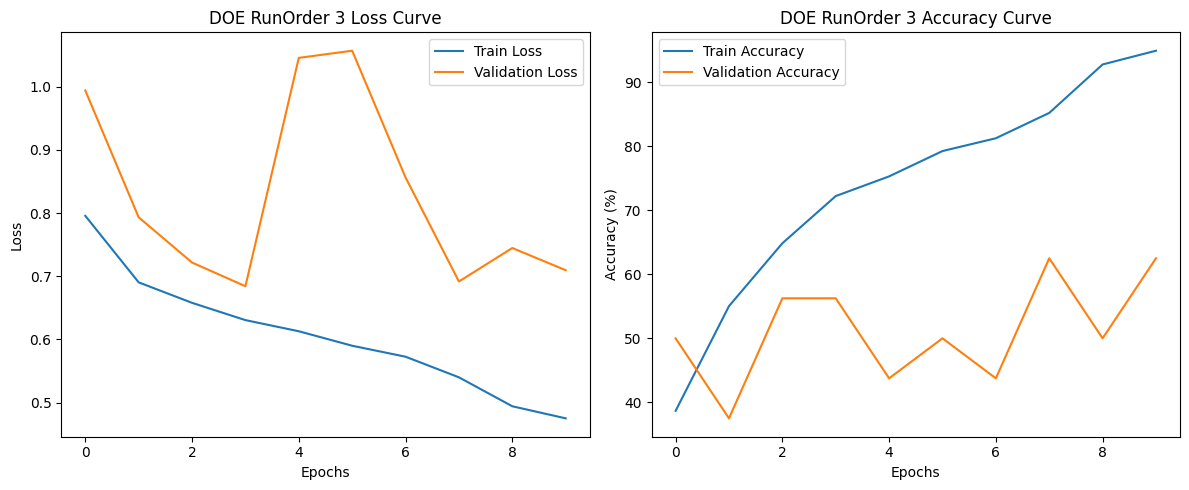

Model weights loaded successfully.
Test Accuracy: 61.25%
Test Loss: 0.6806


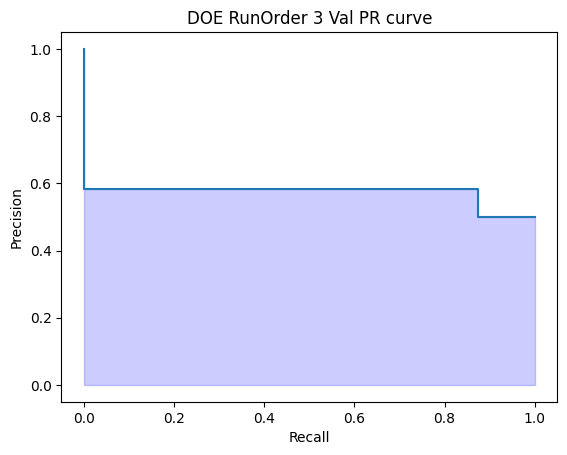

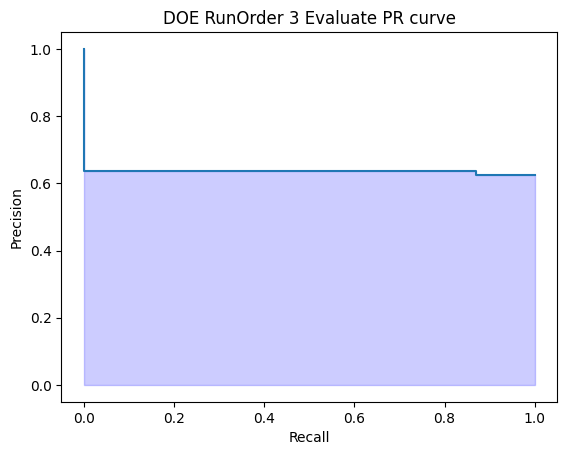

DOE RunOrder 4 Epoch 1/10 - loss: 0.2956 - train_acc: 42.19% - val_loss: 0.2545 - val_acc: 56.25% - time: 79.68s
DOE RunOrder 4 Epoch 2/10 - loss: 0.2415 - train_acc: 59.52% - val_loss: 0.2550 - val_acc: 50.00% - time: 81.19s
DOE RunOrder 4 Epoch 3/10 - loss: 0.2197 - train_acc: 73.58% - val_loss: 0.2970 - val_acc: 62.50% - time: 82.84s
DOE RunOrder 4 Epoch 4/10 - loss: 0.2031 - train_acc: 77.83% - val_loss: 0.2932 - val_acc: 56.25% - time: 80.26s
DOE RunOrder 4 Epoch 5/10 - loss: 0.2001 - train_acc: 78.03% - val_loss: 0.3837 - val_acc: 50.00% - time: 81.17s
DOE RunOrder 4 Epoch 6/10 - loss: 0.1741 - train_acc: 86.08% - val_loss: 0.4526 - val_acc: 50.00% - time: 80.80s
DOE RunOrder 4 Epoch 7/10 - loss: 0.1471 - train_acc: 91.41% - val_loss: 0.4038 - val_acc: 56.25% - time: 83.34s
DOE RunOrder 4 Epoch 8/10 - loss: 0.1197 - train_acc: 95.85% - val_loss: 0.2682 - val_acc: 56.25% - time: 79.91s
DOE RunOrder 4 Epoch 9/10 - loss: 0.1077 - train_acc: 97.07% - val_loss: 0.2657 - val_acc: 50.00

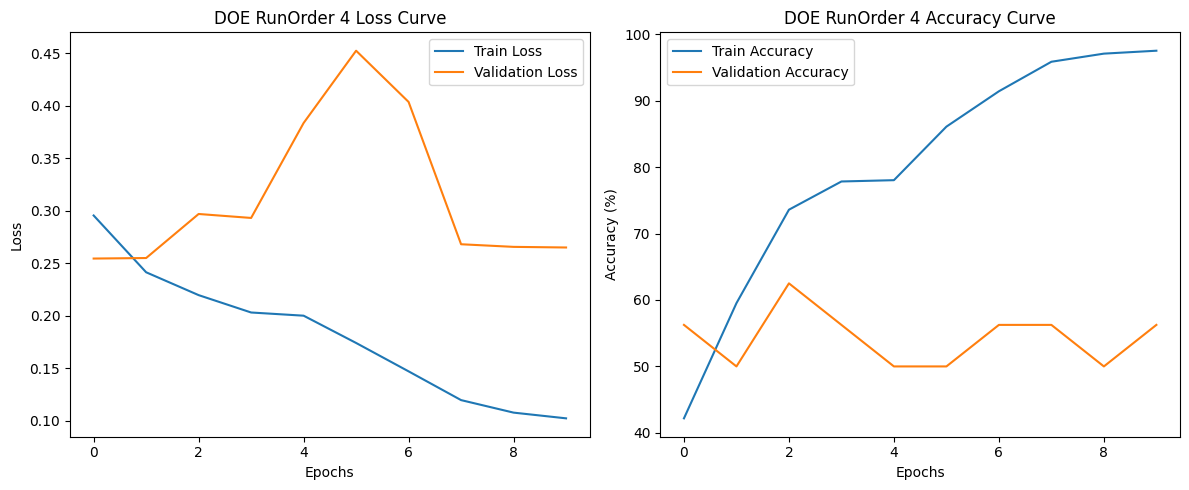

Model weights loaded successfully.
Test Accuracy: 59.53%
Test Loss: 0.2446


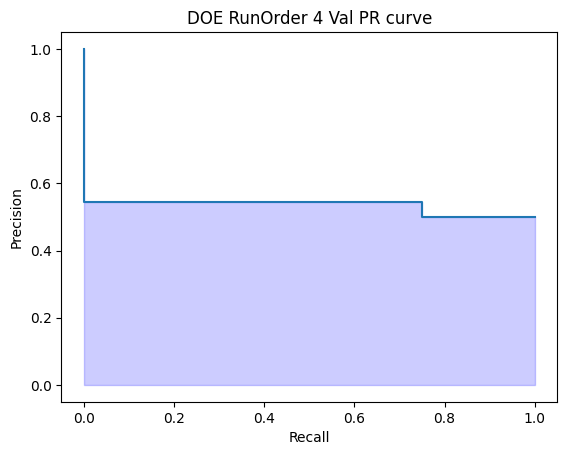

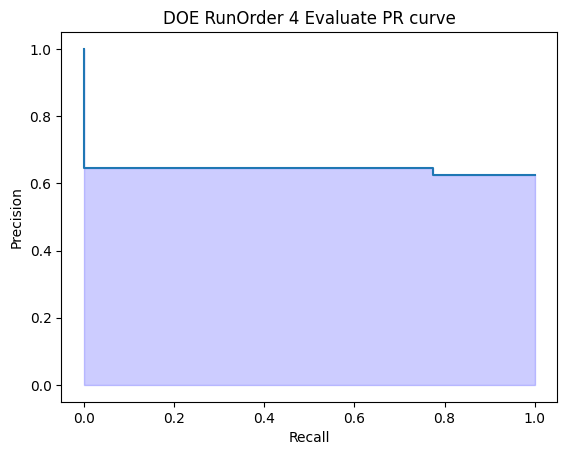

DOE RunOrder 5 Epoch 1/10 - loss: 0.7331 - train_acc: 51.46% - val_loss: 0.9200 - val_acc: 50.00% - time: 80.55s
DOE RunOrder 5 Epoch 2/10 - loss: 0.6814 - train_acc: 59.18% - val_loss: 0.8185 - val_acc: 50.00% - time: 81.44s
DOE RunOrder 5 Epoch 3/10 - loss: 0.6426 - train_acc: 67.48% - val_loss: 0.7139 - val_acc: 62.50% - time: 80.95s
DOE RunOrder 5 Epoch 4/10 - loss: 0.6174 - train_acc: 71.04% - val_loss: 0.6712 - val_acc: 56.25% - time: 81.54s
DOE RunOrder 5 Epoch 5/10 - loss: 0.5969 - train_acc: 76.12% - val_loss: 0.7329 - val_acc: 50.00% - time: 80.56s
DOE RunOrder 5 Epoch 6/10 - loss: 0.5785 - train_acc: 81.10% - val_loss: 0.6467 - val_acc: 56.25% - time: 80.33s
DOE RunOrder 5 Epoch 7/10 - loss: 0.5586 - train_acc: 84.81% - val_loss: 0.6937 - val_acc: 43.75% - time: 79.96s
DOE RunOrder 5 Epoch 8/10 - loss: 0.5395 - train_acc: 87.21% - val_loss: 0.6701 - val_acc: 50.00% - time: 80.75s
DOE RunOrder 5 Epoch 9/10 - loss: 0.5212 - train_acc: 91.21% - val_loss: 0.6470 - val_acc: 68.75

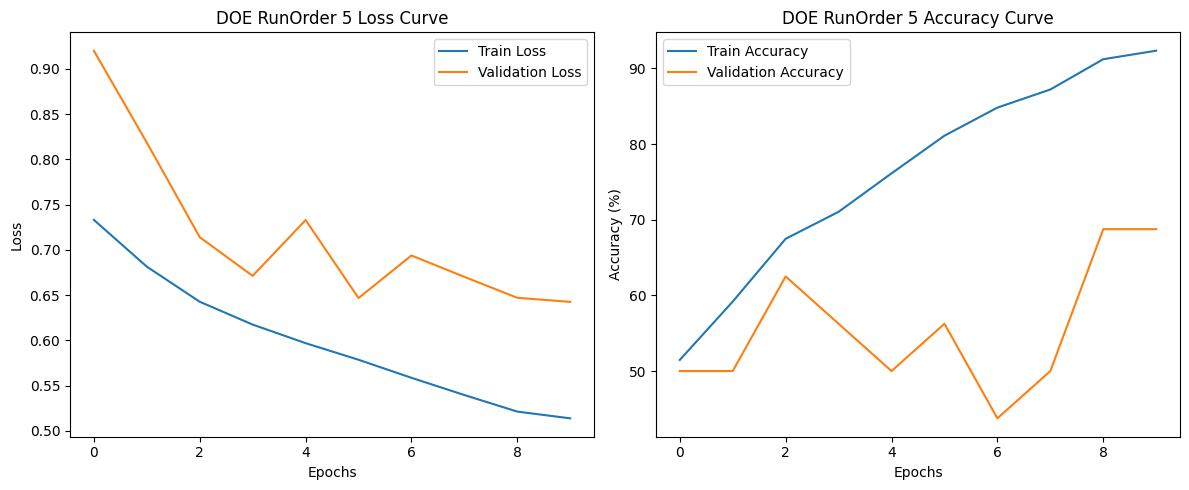

Model weights loaded successfully.
Test Accuracy: 62.97%
Test Loss: 0.6804


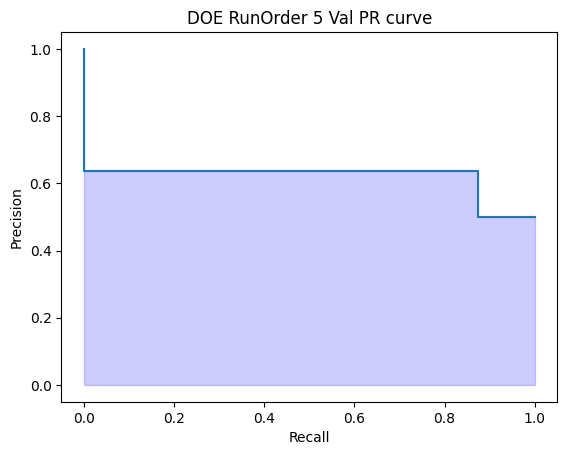

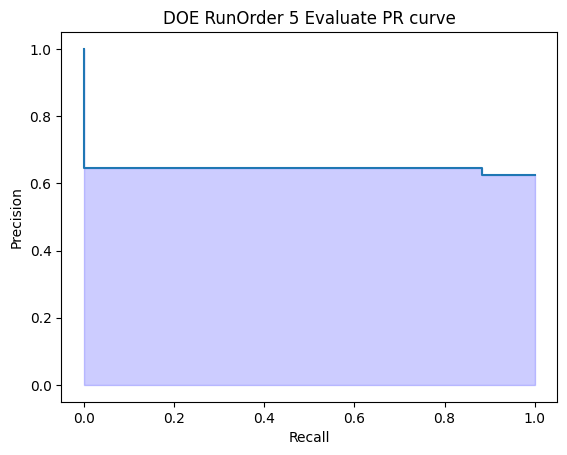

DOE RunOrder 6 Epoch 1/10 - loss: 0.2648 - train_acc: 54.00% - val_loss: 0.2950 - val_acc: 62.50% - time: 80.71s
DOE RunOrder 6 Epoch 2/10 - loss: 0.2393 - train_acc: 64.06% - val_loss: 0.3018 - val_acc: 56.25% - time: 81.14s
DOE RunOrder 6 Epoch 3/10 - loss: 0.2170 - train_acc: 75.10% - val_loss: 0.3223 - val_acc: 62.50% - time: 80.20s
DOE RunOrder 6 Epoch 4/10 - loss: 0.2036 - train_acc: 80.22% - val_loss: 0.2496 - val_acc: 56.25% - time: 80.75s
DOE RunOrder 6 Epoch 5/10 - loss: 0.1896 - train_acc: 85.74% - val_loss: 0.3095 - val_acc: 50.00% - time: 80.01s
DOE RunOrder 6 Epoch 6/10 - loss: 0.1778 - train_acc: 88.77% - val_loss: 0.2100 - val_acc: 68.75% - time: 80.43s
DOE RunOrder 6 Epoch 7/10 - loss: 0.1760 - train_acc: 89.26% - val_loss: 0.2108 - val_acc: 68.75% - time: 80.08s
DOE RunOrder 6 Epoch 8/10 - loss: 0.1742 - train_acc: 89.89% - val_loss: 0.2114 - val_acc: 62.50% - time: 80.06s
DOE RunOrder 6 Epoch 9/10 - loss: 0.1726 - train_acc: 90.62% - val_loss: 0.2126 - val_acc: 56.25

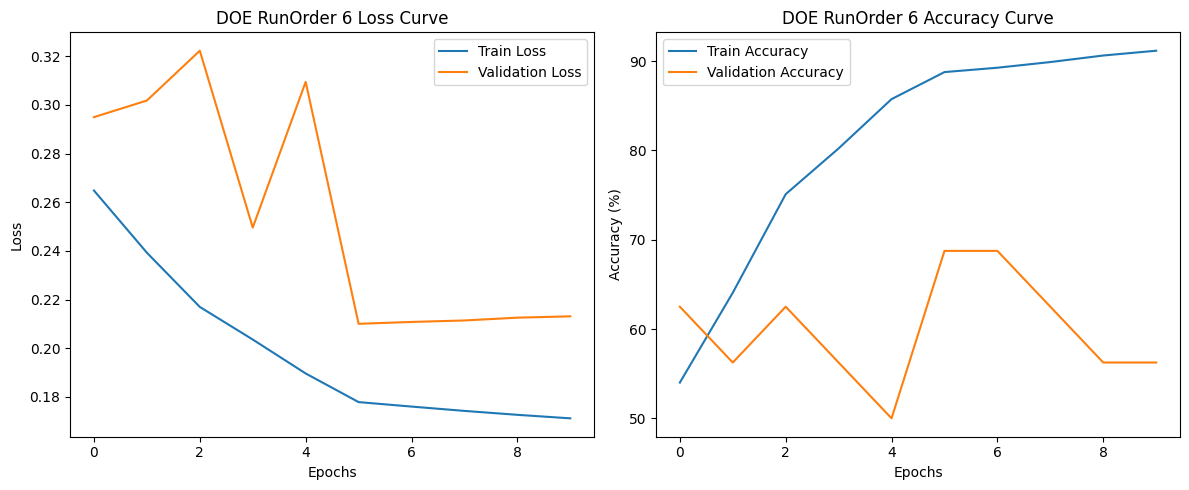

Model weights loaded successfully.
Test Accuracy: 62.19%
Test Loss: 0.2620


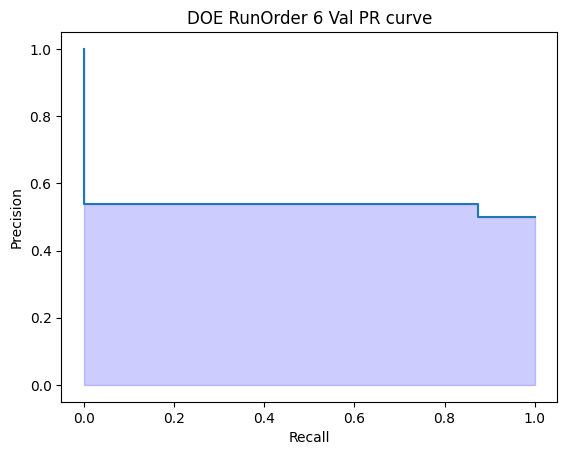

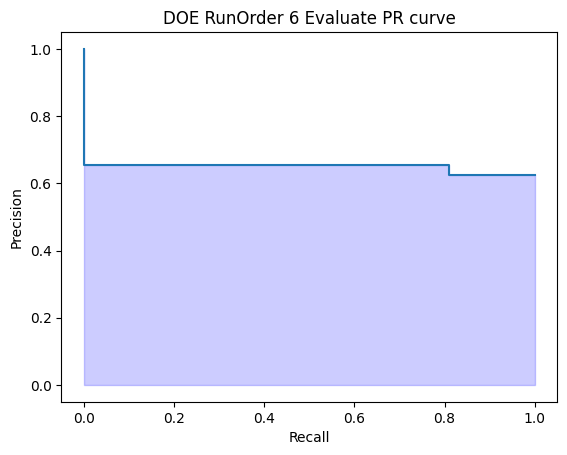

DOE RunOrder 7 Epoch 1/10 - loss: 0.2671 - train_acc: 54.39% - val_loss: 0.3576 - val_acc: 56.25% - time: 85.79s
DOE RunOrder 7 Epoch 2/10 - loss: 0.2421 - train_acc: 63.67% - val_loss: 0.2667 - val_acc: 56.25% - time: 79.99s
DOE RunOrder 7 Epoch 3/10 - loss: 0.2172 - train_acc: 76.81% - val_loss: 0.2828 - val_acc: 62.50% - time: 81.42s
DOE RunOrder 7 Epoch 4/10 - loss: 0.2032 - train_acc: 80.76% - val_loss: 0.2387 - val_acc: 62.50% - time: 79.65s
DOE RunOrder 7 Epoch 5/10 - loss: 0.1885 - train_acc: 87.11% - val_loss: 0.3096 - val_acc: 43.75% - time: 80.87s
DOE RunOrder 7 Epoch 6/10 - loss: 0.1795 - train_acc: 89.11% - val_loss: 0.3185 - val_acc: 56.25% - time: 79.47s
DOE RunOrder 7 Epoch 7/10 - loss: 0.1677 - train_acc: 92.29% - val_loss: 0.3588 - val_acc: 62.50% - time: 81.09s
DOE RunOrder 7 Epoch 8/10 - loss: 0.1628 - train_acc: 92.72% - val_loss: 0.2551 - val_acc: 56.25% - time: 79.21s
DOE RunOrder 7 Epoch 9/10 - loss: 0.1604 - train_acc: 93.31% - val_loss: 0.2484 - val_acc: 68.75

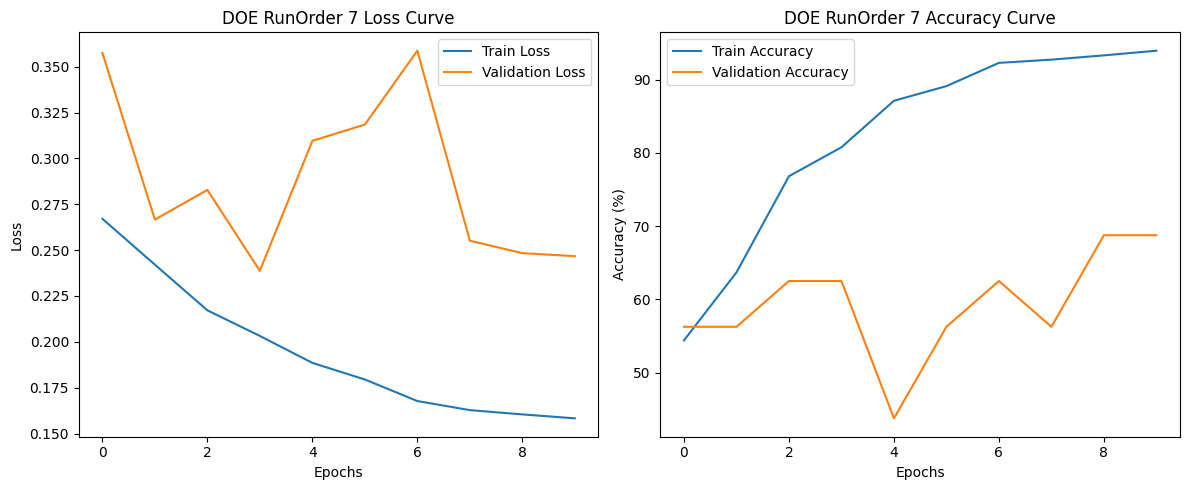

Model weights loaded successfully.
Test Accuracy: 66.41%
Test Loss: 0.2469


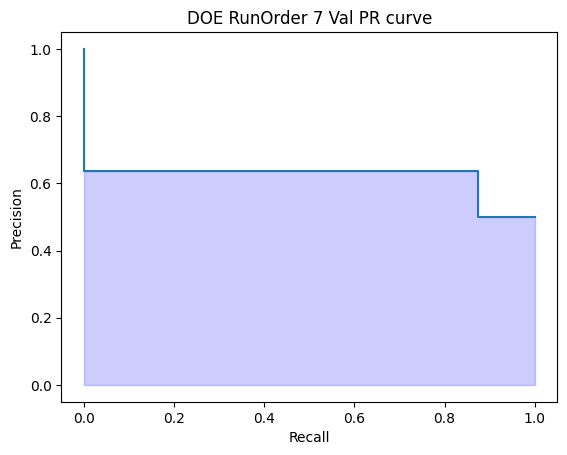

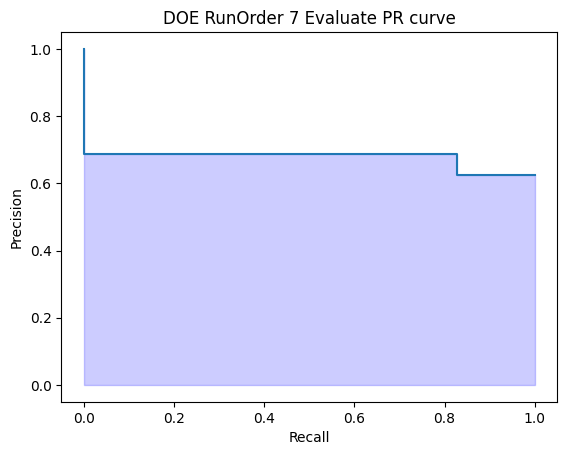

DOE RunOrder 8 Epoch 1/10 - loss: 0.2935 - train_acc: 42.43% - val_loss: 0.2973 - val_acc: 56.25% - time: 79.63s
DOE RunOrder 8 Epoch 2/10 - loss: 0.2434 - train_acc: 58.94% - val_loss: 0.2863 - val_acc: 56.25% - time: 80.90s
DOE RunOrder 8 Epoch 3/10 - loss: 0.2289 - train_acc: 69.14% - val_loss: 0.3394 - val_acc: 56.25% - time: 79.49s
DOE RunOrder 8 Epoch 4/10 - loss: 0.2243 - train_acc: 69.04% - val_loss: 0.2621 - val_acc: 43.75% - time: 81.26s
DOE RunOrder 8 Epoch 5/10 - loss: 0.2228 - train_acc: 68.21% - val_loss: 0.3877 - val_acc: 43.75% - time: 79.34s
DOE RunOrder 8 Epoch 6/10 - loss: 0.2016 - train_acc: 77.59% - val_loss: 0.3207 - val_acc: 43.75% - time: 81.17s
DOE RunOrder 8 Epoch 7/10 - loss: 0.1992 - train_acc: 78.81% - val_loss: 0.3160 - val_acc: 50.00% - time: 79.24s
DOE RunOrder 8 Epoch 8/10 - loss: 0.1968 - train_acc: 80.27% - val_loss: 0.3139 - val_acc: 50.00% - time: 81.12s
DOE RunOrder 8 Epoch 9/10 - loss: 0.1946 - train_acc: 81.45% - val_loss: 0.3116 - val_acc: 50.00

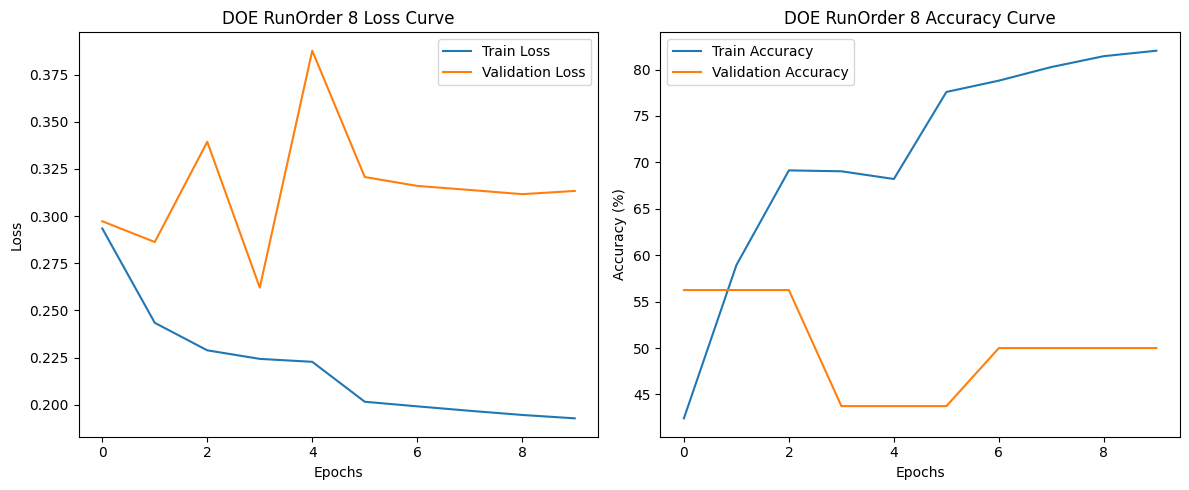

Model weights loaded successfully.
Test Accuracy: 58.23%
Test Loss: 0.2609


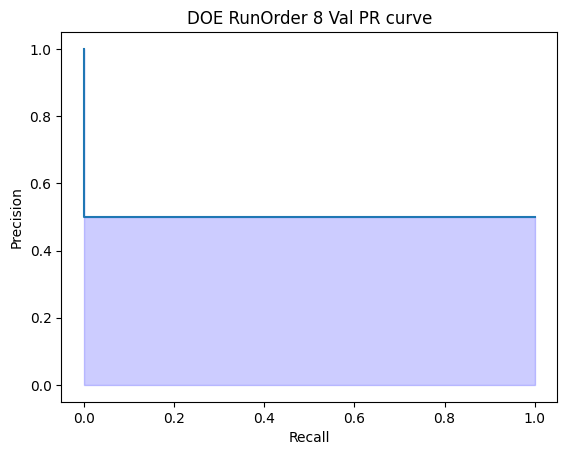

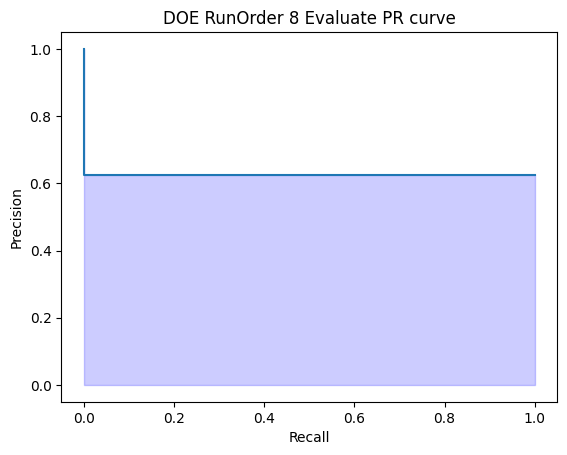

DOE RunOrder 9 Epoch 1/10 - loss: 0.7865 - train_acc: 39.60% - val_loss: 0.7521 - val_acc: 43.75% - time: 81.03s
DOE RunOrder 9 Epoch 2/10 - loss: 0.6849 - train_acc: 57.42% - val_loss: 0.7569 - val_acc: 43.75% - time: 79.71s
DOE RunOrder 9 Epoch 3/10 - loss: 0.6503 - train_acc: 68.85% - val_loss: 0.6855 - val_acc: 56.25% - time: 80.46s
DOE RunOrder 9 Epoch 4/10 - loss: 0.6235 - train_acc: 73.97% - val_loss: 0.7140 - val_acc: 56.25% - time: 79.78s
DOE RunOrder 9 Epoch 5/10 - loss: 0.5965 - train_acc: 79.25% - val_loss: 0.6491 - val_acc: 62.50% - time: 80.12s
DOE RunOrder 9 Epoch 6/10 - loss: 0.5684 - train_acc: 83.54% - val_loss: 0.7441 - val_acc: 50.00% - time: 79.70s
DOE RunOrder 9 Epoch 7/10 - loss: 0.5505 - train_acc: 85.35% - val_loss: 1.0505 - val_acc: 56.25% - time: 80.22s
DOE RunOrder 9 Epoch 8/10 - loss: 0.5302 - train_acc: 88.13% - val_loss: 0.9070 - val_acc: 50.00% - time: 80.73s
DOE RunOrder 9 Epoch 9/10 - loss: 0.4967 - train_acc: 92.14% - val_loss: 0.7356 - val_acc: 50.00

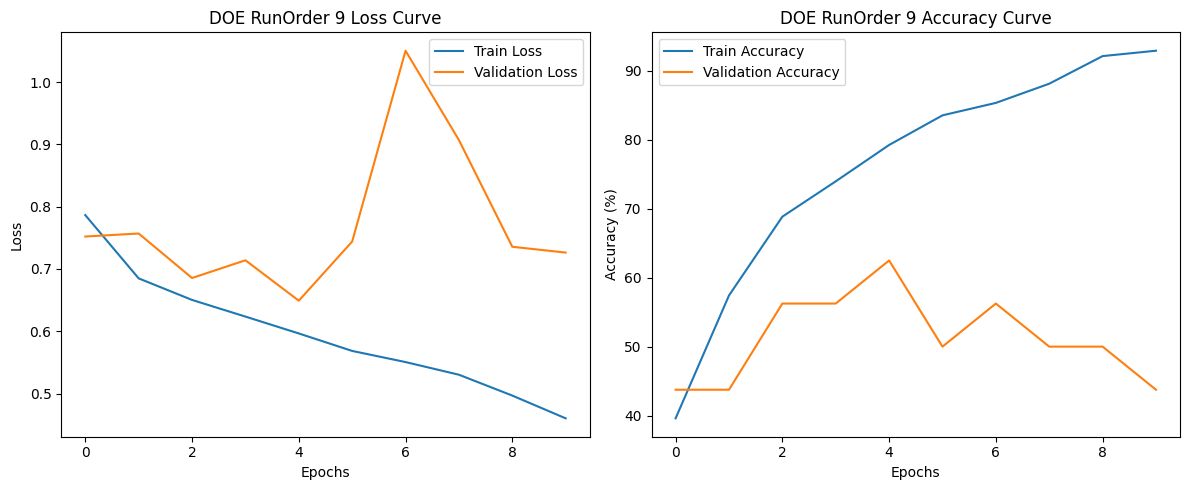

Model weights loaded successfully.
Test Accuracy: 41.41%
Test Loss: 0.7608


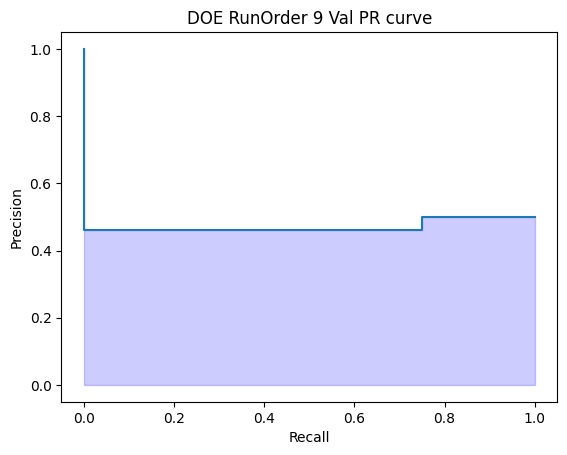

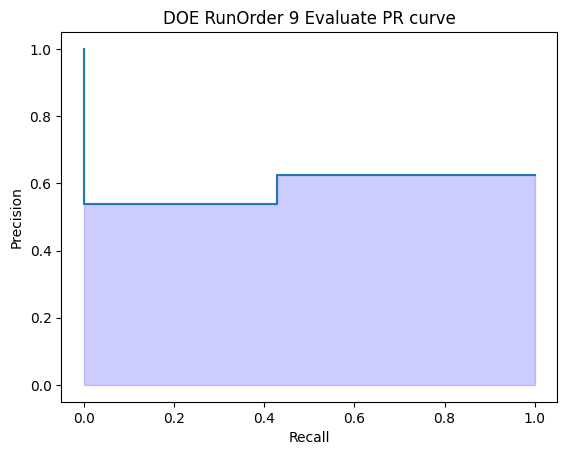

DOE RunOrder 10 Epoch 1/10 - loss: 0.2664 - train_acc: 51.51% - val_loss: 0.3798 - val_acc: 50.00% - time: 80.49s
DOE RunOrder 10 Epoch 2/10 - loss: 0.2390 - train_acc: 60.50% - val_loss: 0.2492 - val_acc: 37.50% - time: 80.36s
DOE RunOrder 10 Epoch 3/10 - loss: 0.2217 - train_acc: 71.48% - val_loss: 0.2379 - val_acc: 68.75% - time: 80.62s
DOE RunOrder 10 Epoch 4/10 - loss: 0.2105 - train_acc: 77.29% - val_loss: 0.2690 - val_acc: 50.00% - time: 80.30s
DOE RunOrder 10 Epoch 5/10 - loss: 0.1984 - train_acc: 84.03% - val_loss: 0.2730 - val_acc: 62.50% - time: 80.13s
DOE RunOrder 10 Epoch 6/10 - loss: 0.1906 - train_acc: 85.89% - val_loss: 0.2496 - val_acc: 50.00% - time: 80.07s
DOE RunOrder 10 Epoch 7/10 - loss: 0.1833 - train_acc: 89.06% - val_loss: 0.2603 - val_acc: 43.75% - time: 80.13s
DOE RunOrder 10 Epoch 8/10 - loss: 0.1723 - train_acc: 91.50% - val_loss: 0.2066 - val_acc: 75.00% - time: 80.26s
DOE RunOrder 10 Epoch 9/10 - loss: 0.1651 - train_acc: 93.90% - val_loss: 0.1994 - val_a

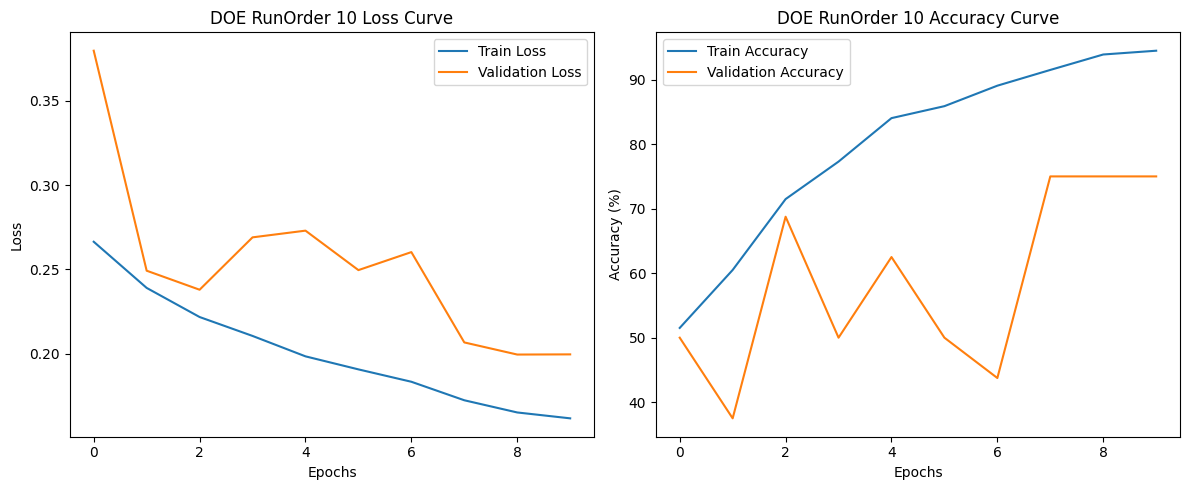

Model weights loaded successfully.
Test Accuracy: 64.95%
Test Loss: 0.2432


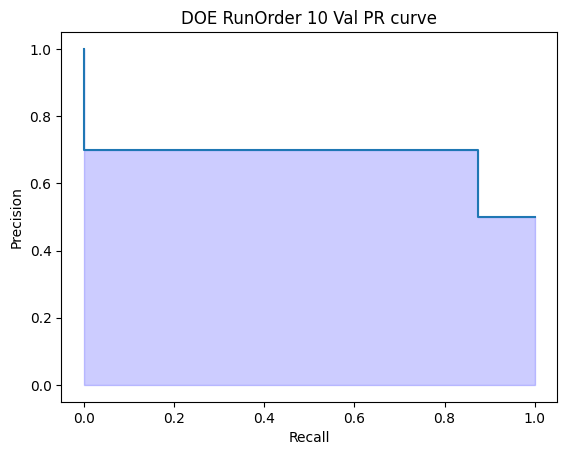

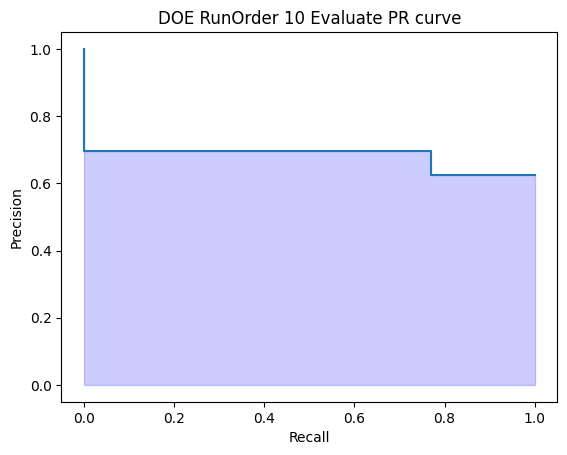

DOE RunOrder 11 Epoch 1/10 - loss: 0.7798 - train_acc: 39.16% - val_loss: 0.8138 - val_acc: 50.00% - time: 79.59s
DOE RunOrder 11 Epoch 2/10 - loss: 0.6610 - train_acc: 59.62% - val_loss: 0.7438 - val_acc: 62.50% - time: 80.64s
DOE RunOrder 11 Epoch 3/10 - loss: 0.6303 - train_acc: 70.51% - val_loss: 0.7931 - val_acc: 43.75% - time: 79.60s
DOE RunOrder 11 Epoch 4/10 - loss: 0.6031 - train_acc: 76.51% - val_loss: 0.8297 - val_acc: 56.25% - time: 80.68s
DOE RunOrder 11 Epoch 5/10 - loss: 0.5767 - train_acc: 81.30% - val_loss: 0.8085 - val_acc: 56.25% - time: 79.64s
DOE RunOrder 11 Epoch 6/10 - loss: 0.5453 - train_acc: 86.08% - val_loss: 0.8059 - val_acc: 56.25% - time: 80.85s
DOE RunOrder 11 Epoch 7/10 - loss: 0.5124 - train_acc: 90.53% - val_loss: 0.7491 - val_acc: 56.25% - time: 80.04s
DOE RunOrder 11 Epoch 8/10 - loss: 0.4809 - train_acc: 93.99% - val_loss: 0.7338 - val_acc: 68.75% - time: 80.73s
DOE RunOrder 11 Epoch 9/10 - loss: 0.4690 - train_acc: 95.65% - val_loss: 0.7077 - val_a

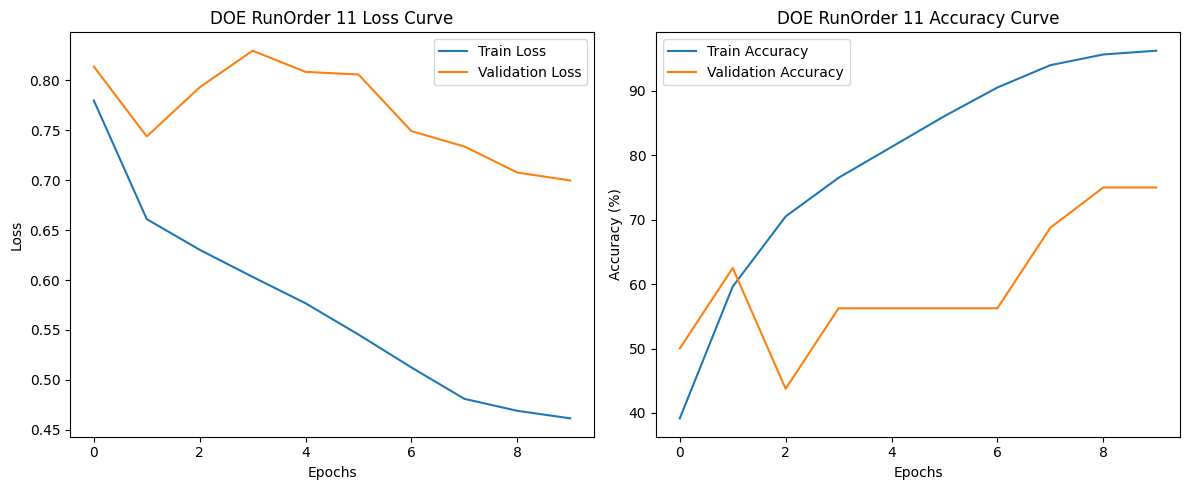

Model weights loaded successfully.
Test Accuracy: 62.14%
Test Loss: 0.6612


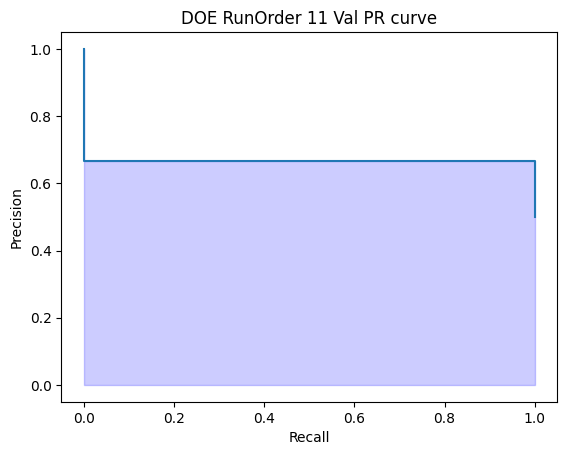

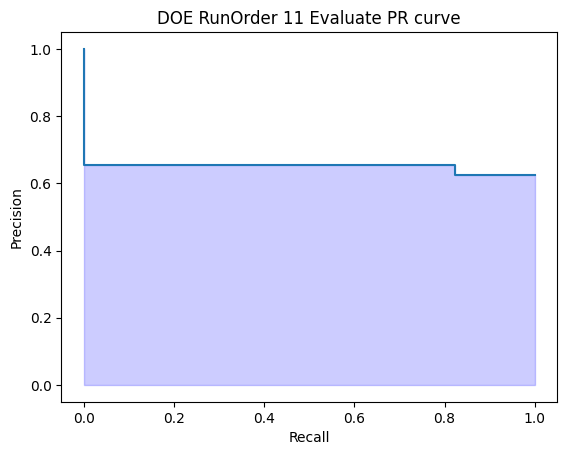

DOE RunOrder 12 Epoch 1/10 - loss: 0.7106 - train_acc: 53.52% - val_loss: 0.8496 - val_acc: 56.25% - time: 80.11s
DOE RunOrder 12 Epoch 2/10 - loss: 0.6721 - train_acc: 60.50% - val_loss: 0.7195 - val_acc: 43.75% - time: 79.28s
DOE RunOrder 12 Epoch 3/10 - loss: 0.6355 - train_acc: 69.29% - val_loss: 0.5877 - val_acc: 81.25% - time: 80.29s
DOE RunOrder 12 Epoch 4/10 - loss: 0.6045 - train_acc: 77.00% - val_loss: 0.7104 - val_acc: 56.25% - time: 79.12s
DOE RunOrder 12 Epoch 5/10 - loss: 0.5838 - train_acc: 81.35% - val_loss: 0.6711 - val_acc: 50.00% - time: 81.09s
DOE RunOrder 12 Epoch 6/10 - loss: 0.5601 - train_acc: 86.38% - val_loss: 0.7390 - val_acc: 56.25% - time: 79.57s
DOE RunOrder 12 Epoch 7/10 - loss: 0.5442 - train_acc: 88.23% - val_loss: 0.8352 - val_acc: 50.00% - time: 81.02s
DOE RunOrder 12 Epoch 8/10 - loss: 0.5315 - train_acc: 87.94% - val_loss: 0.6981 - val_acc: 43.75% - time: 81.03s
DOE RunOrder 12 Epoch 9/10 - loss: 0.5273 - train_acc: 88.82% - val_loss: 0.6979 - val_a

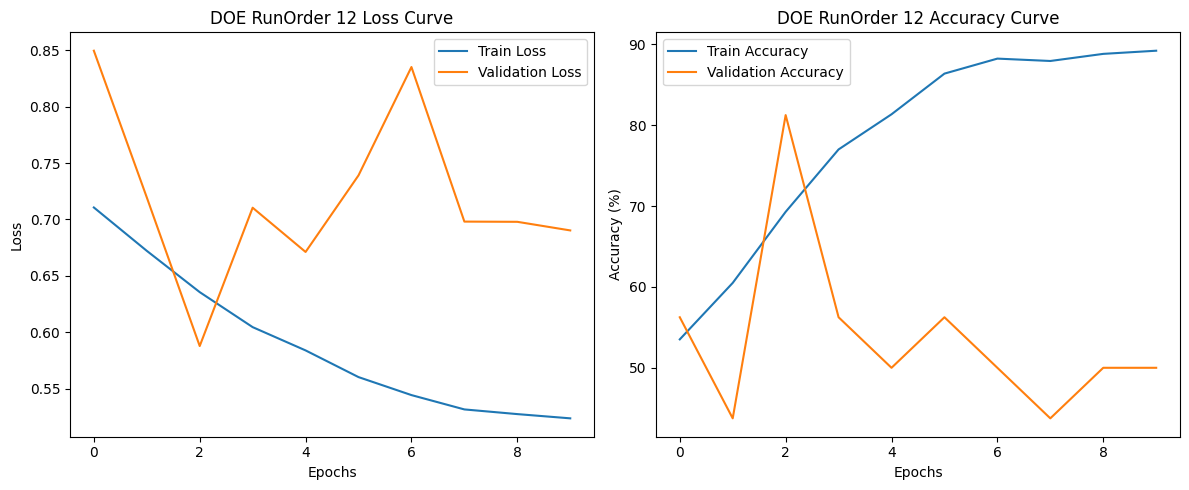

Model weights loaded successfully.
Test Accuracy: 59.22%
Test Loss: 0.6697


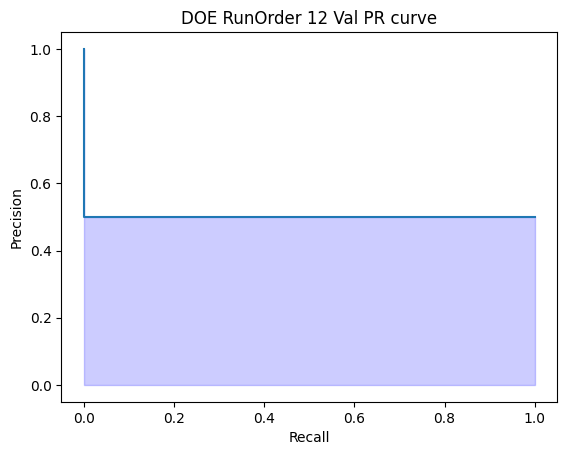

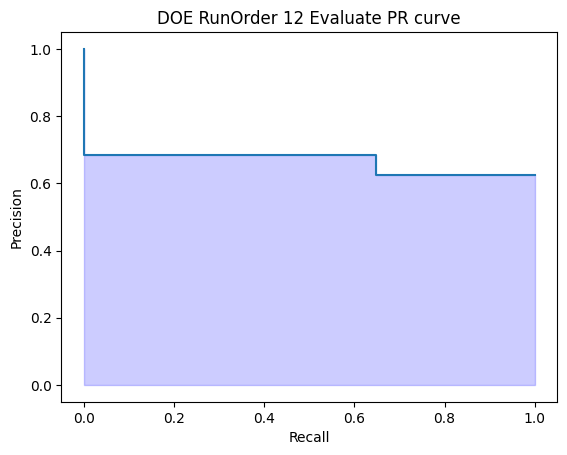

DOE RunOrder 13 Epoch 1/10 - loss: 0.7827 - train_acc: 39.89% - val_loss: 0.7975 - val_acc: 56.25% - time: 79.87s
DOE RunOrder 13 Epoch 2/10 - loss: 0.6686 - train_acc: 59.77% - val_loss: 0.6742 - val_acc: 68.75% - time: 80.57s
DOE RunOrder 13 Epoch 3/10 - loss: 0.6354 - train_acc: 69.14% - val_loss: 0.6441 - val_acc: 56.25% - time: 79.74s
DOE RunOrder 13 Epoch 4/10 - loss: 0.6065 - train_acc: 74.22% - val_loss: 0.9311 - val_acc: 37.50% - time: 81.66s
DOE RunOrder 13 Epoch 5/10 - loss: 0.5883 - train_acc: 78.61% - val_loss: 1.2173 - val_acc: 50.00% - time: 81.02s
DOE RunOrder 13 Epoch 6/10 - loss: 0.5669 - train_acc: 79.69% - val_loss: 1.3090 - val_acc: 31.25% - time: 80.66s
DOE RunOrder 13 Epoch 7/10 - loss: 0.5182 - train_acc: 86.57% - val_loss: 0.7402 - val_acc: 43.75% - time: 81.13s
DOE RunOrder 13 Epoch 8/10 - loss: 0.5119 - train_acc: 87.50% - val_loss: 0.7314 - val_acc: 50.00% - time: 80.22s
DOE RunOrder 13 Epoch 9/10 - loss: 0.5060 - train_acc: 88.53% - val_loss: 0.7272 - val_a

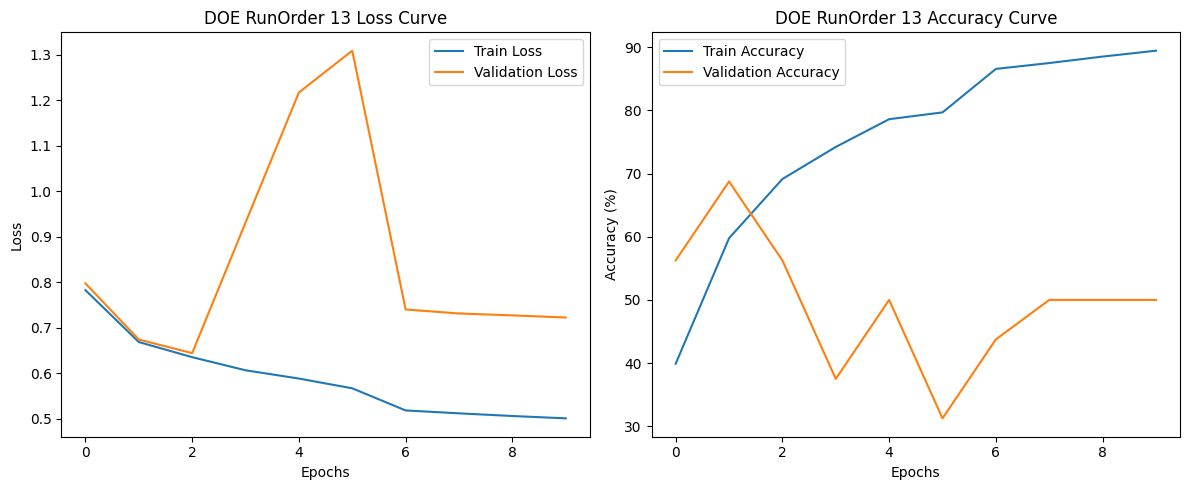

Model weights loaded successfully.
Test Accuracy: 44.74%
Test Loss: 0.7533


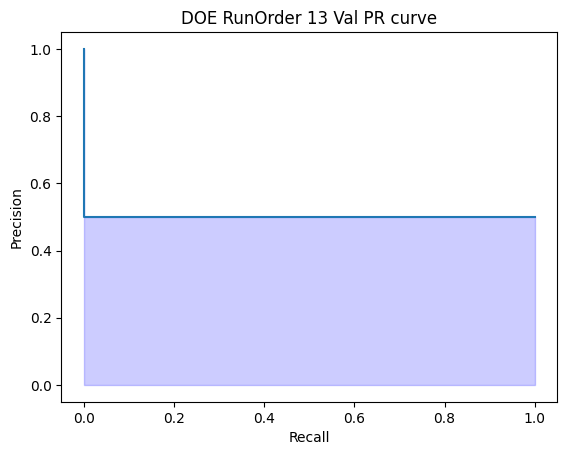

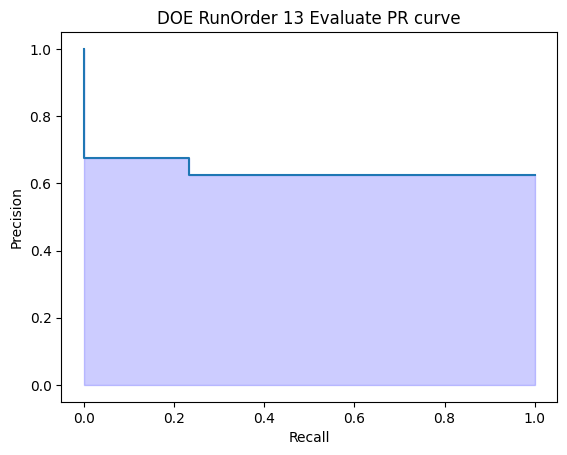

DOE RunOrder 14 Epoch 1/10 - loss: 0.7236 - train_acc: 49.27% - val_loss: 0.6557 - val_acc: 68.75% - time: 79.95s
DOE RunOrder 14 Epoch 2/10 - loss: 0.6760 - train_acc: 60.06% - val_loss: 0.8724 - val_acc: 25.00% - time: 80.41s
DOE RunOrder 14 Epoch 3/10 - loss: 0.6426 - train_acc: 68.16% - val_loss: 0.7524 - val_acc: 56.25% - time: 79.37s
DOE RunOrder 14 Epoch 4/10 - loss: 0.6200 - train_acc: 74.95% - val_loss: 0.7202 - val_acc: 50.00% - time: 78.60s
DOE RunOrder 14 Epoch 5/10 - loss: 0.5942 - train_acc: 80.81% - val_loss: 0.7988 - val_acc: 25.00% - time: 80.38s
DOE RunOrder 14 Epoch 6/10 - loss: 0.5709 - train_acc: 85.50% - val_loss: 0.7396 - val_acc: 37.50% - time: 79.98s
DOE RunOrder 14 Epoch 7/10 - loss: 0.5685 - train_acc: 86.28% - val_loss: 0.7347 - val_acc: 43.75% - time: 80.78s
DOE RunOrder 14 Epoch 8/10 - loss: 0.5662 - train_acc: 86.62% - val_loss: 0.7320 - val_acc: 50.00% - time: 79.61s
DOE RunOrder 14 Epoch 9/10 - loss: 0.5642 - train_acc: 86.91% - val_loss: 0.7310 - val_a

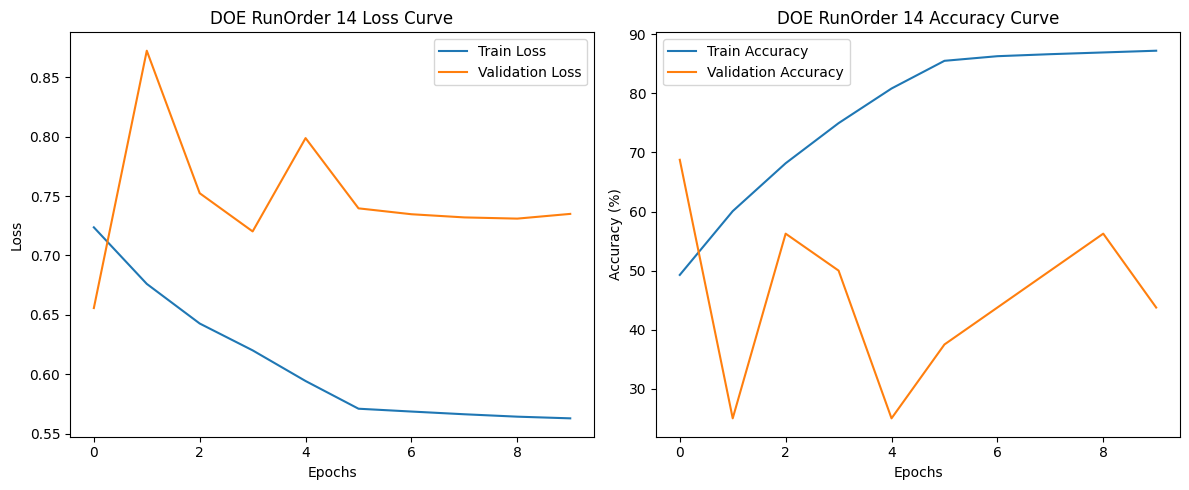

Model weights loaded successfully.
Test Accuracy: 57.50%
Test Loss: 0.6884


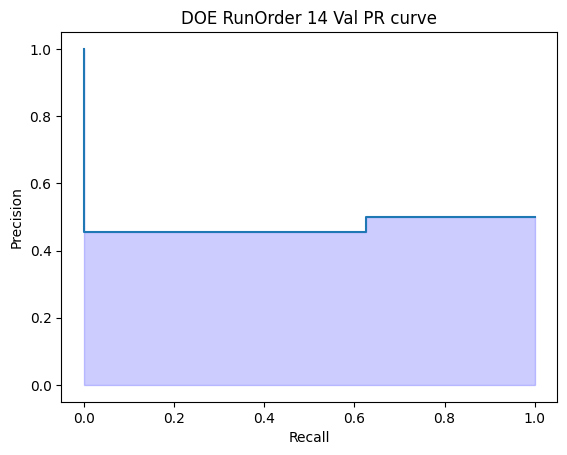

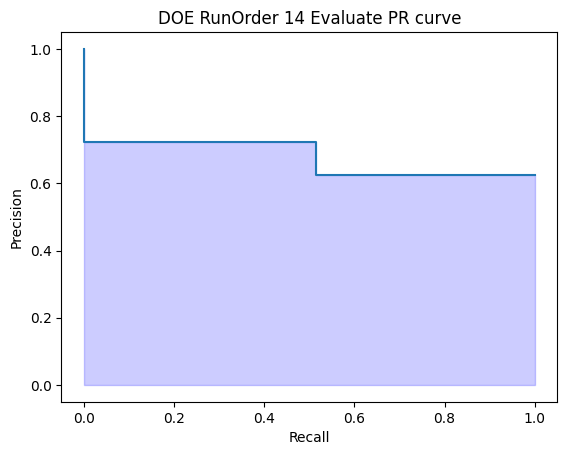

DOE RunOrder 15 Epoch 1/10 - loss: 0.7186 - train_acc: 49.71% - val_loss: 0.9407 - val_acc: 56.25% - time: 79.16s
DOE RunOrder 15 Epoch 2/10 - loss: 0.6722 - train_acc: 59.77% - val_loss: 1.0237 - val_acc: 43.75% - time: 80.65s
DOE RunOrder 15 Epoch 3/10 - loss: 0.6375 - train_acc: 69.14% - val_loss: 0.6410 - val_acc: 62.50% - time: 78.91s
DOE RunOrder 15 Epoch 4/10 - loss: 0.6123 - train_acc: 75.29% - val_loss: 0.6289 - val_acc: 62.50% - time: 80.94s
DOE RunOrder 15 Epoch 5/10 - loss: 0.5898 - train_acc: 82.18% - val_loss: 0.6074 - val_acc: 68.75% - time: 79.05s
DOE RunOrder 15 Epoch 6/10 - loss: 0.5697 - train_acc: 85.16% - val_loss: 0.7382 - val_acc: 43.75% - time: 80.35s
DOE RunOrder 15 Epoch 7/10 - loss: 0.5538 - train_acc: 87.99% - val_loss: 0.8253 - val_acc: 50.00% - time: 78.99s
DOE RunOrder 15 Epoch 8/10 - loss: 0.5407 - train_acc: 90.19% - val_loss: 0.9153 - val_acc: 50.00% - time: 80.37s
DOE RunOrder 15 Epoch 9/10 - loss: 0.5305 - train_acc: 90.33% - val_loss: 0.6879 - val_a

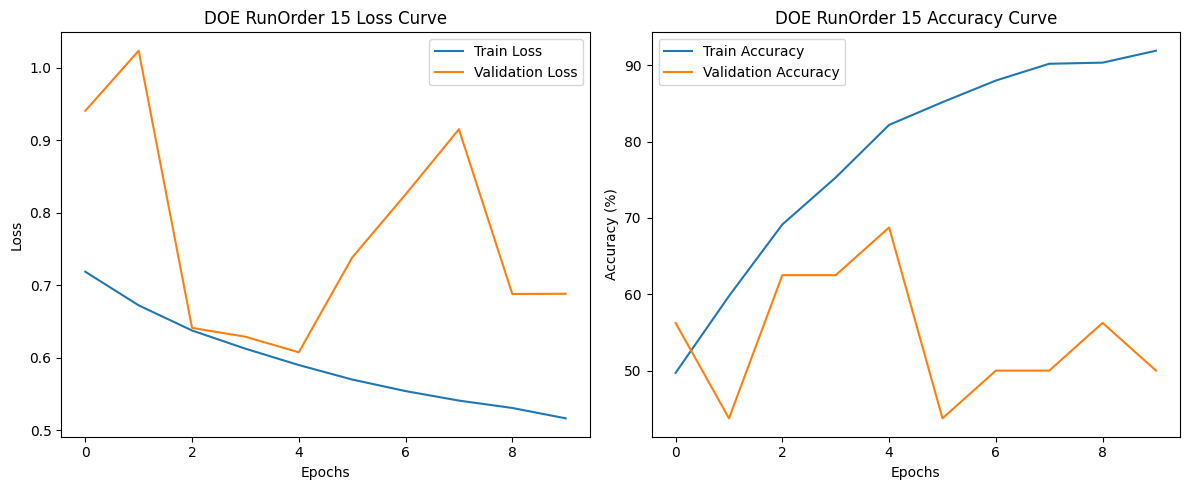

Model weights loaded successfully.
Test Accuracy: 70.10%
Test Loss: 0.5936


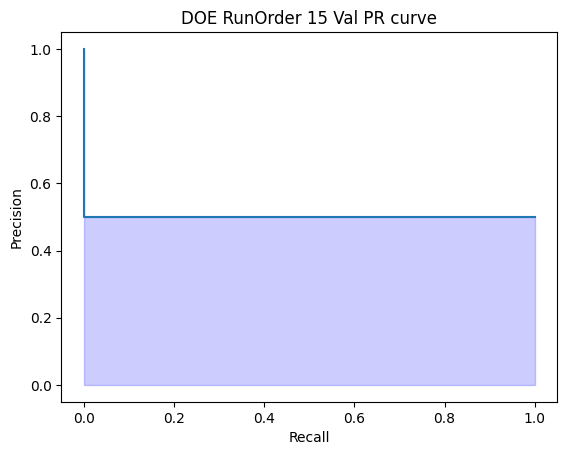

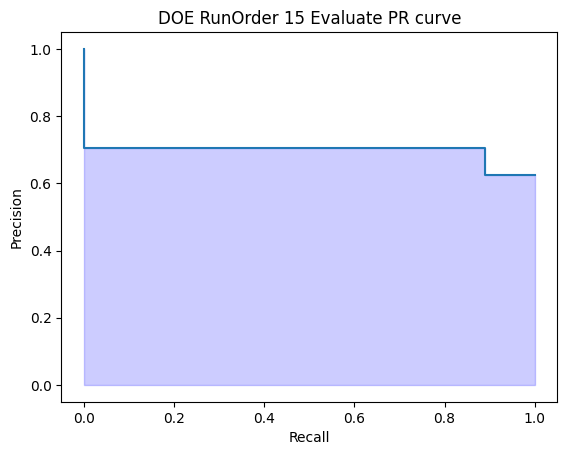

DOE RunOrder 16 Epoch 1/10 - loss: 0.2606 - train_acc: 51.27% - val_loss: 0.3830 - val_acc: 43.75% - time: 79.33s
DOE RunOrder 16 Epoch 2/10 - loss: 0.2384 - train_acc: 61.77% - val_loss: 0.2524 - val_acc: 62.50% - time: 78.92s
DOE RunOrder 16 Epoch 3/10 - loss: 0.2221 - train_acc: 70.41% - val_loss: 0.2632 - val_acc: 62.50% - time: 78.43s
DOE RunOrder 16 Epoch 4/10 - loss: 0.2084 - train_acc: 78.91% - val_loss: 0.2640 - val_acc: 56.25% - time: 79.88s
DOE RunOrder 16 Epoch 5/10 - loss: 0.2001 - train_acc: 82.91% - val_loss: 0.2454 - val_acc: 62.50% - time: 78.06s
DOE RunOrder 16 Epoch 6/10 - loss: 0.1910 - train_acc: 85.35% - val_loss: 0.3008 - val_acc: 50.00% - time: 79.90s
DOE RunOrder 16 Epoch 7/10 - loss: 0.1800 - train_acc: 89.16% - val_loss: 0.2225 - val_acc: 68.75% - time: 78.57s
DOE RunOrder 16 Epoch 8/10 - loss: 0.1731 - train_acc: 92.29% - val_loss: 0.2188 - val_acc: 81.25% - time: 79.83s
DOE RunOrder 16 Epoch 9/10 - loss: 0.1697 - train_acc: 93.07% - val_loss: 0.2165 - val_a

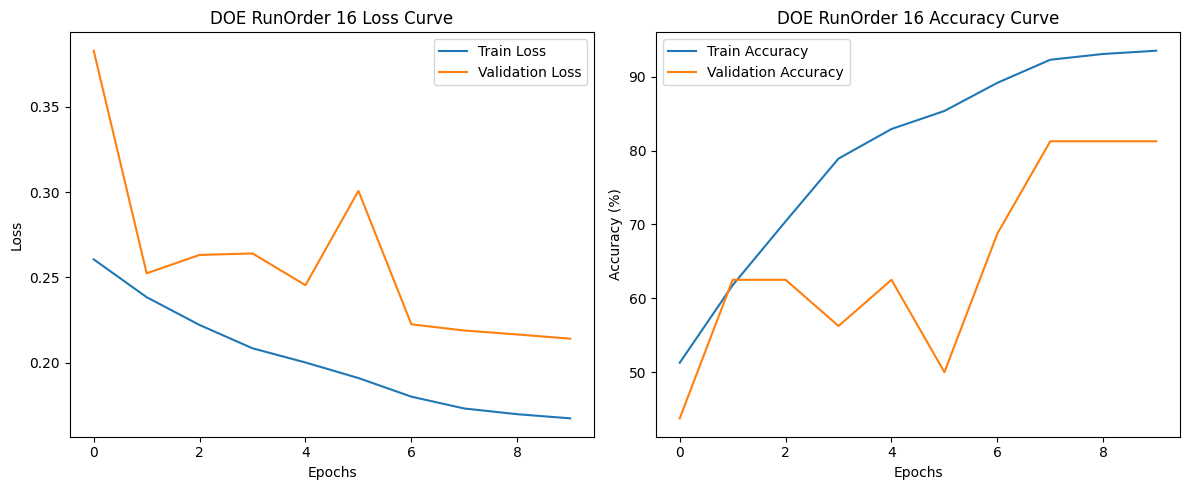

Model weights loaded successfully.
Test Accuracy: 64.79%
Test Loss: 0.2377


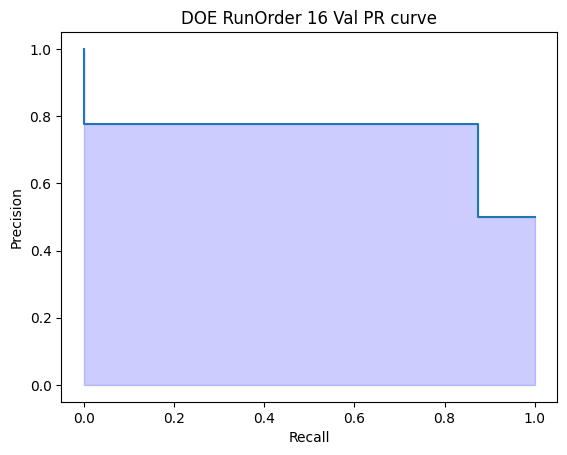

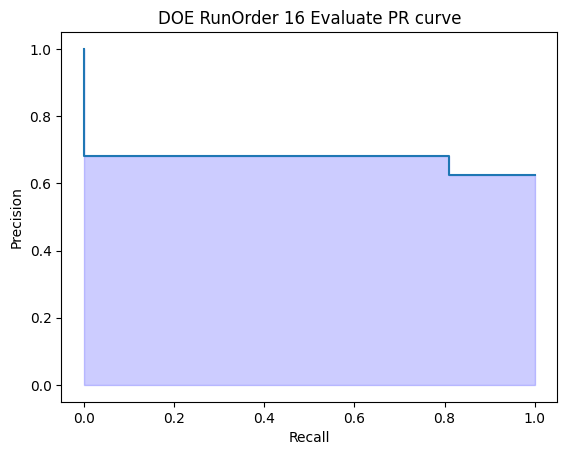

In [ ]:
# DOE FFD with 4 independent varaible and 1 block
summary = pd.DataFrame([])

for i in range(len(doe02)):
  lr = doe02.iloc[i,4]
  weight_decay = doe02.iloc[i,5]
  factor = doe02.iloc[i,6]

  # criterion
  if doe02.iloc[i,7] == 'nn.MSELoss()':
    criterion = nn.MSELoss()
  elif doe02.iloc[i,7] == 'nn.BCELoss()':
    criterion = nn.BCELoss()

  optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
  lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=3, mode='max') # TA's patience=5
  epochs = 10 # TA set defult epochs to 10

  # save checkpoint
  save = 'model'

  # Initial for training
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  best_acc = 0.0
  output_list = []

  # Initial weight with your_seed to keep the same random weights for each initialization
  model.apply(weight_init)

  # Training loop
  for epoch in range(epochs):
    train_loss, train_acc, train_time, train_p, train_l = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc, val_p, val_l = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)

    summary = pd.concat([summary, pd.DataFrame({
        "RunOrder": ['DOE RunOrder ' + str(i+1)],
        "Epoch": [epoch+1],
        "Train Loss": [train_loss],
        "Train Accuracy": [train_acc],
        "Val Loss": [val_loss],
        "Val Accuracy": [val_acc],
        "Total Time": [total_time],
        })])

    print('DOE RunOrder ' + str(i+1) , output_str)
    lr_scheduler.step(val_acc)

  # Graph
  plt.figure(figsize=(12, 5))

  # loss graph
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('DOE RunOrder ' + str(i+1) + ' Loss Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # accuracy graph
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.title('DOE RunOrder ' + str(i+1) + ' Accuracy Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  # show
  plt.tight_layout()
  plt.show()

  # Evalute
  model_path = 'model.pth'
  avg_test_loss, avg_test_acc, eva_p, eva_l = evaluate(model, device, model_path, test_loader)

  # Plot precision-recall curve
  pr_curve = torchmetrics.PrecisionRecallCurve(task='binary')

  # Convert to tensors if they are lists
  train_p = torch.tensor(train_p) if isinstance(train_p, list) else train_p
  train_l = torch.tensor(train_l) if isinstance(train_l, list) else train_l
  val_p = torch.tensor(val_p) if isinstance(val_p, list) else val_p
  val_l = torch.tensor(val_l) if isinstance(val_l, list) else val_l
  eva_p = torch.tensor(eva_p) if isinstance(eva_p, list) else eva_p
  eva_l = torch.tensor(eva_l) if isinstance(eva_l, list) else eva_l

  # Convert to float32
  train_p = train_p.clone().detach() # Use clone and detach to create a copy of the tensor
  train_l = train_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
  val_p = val_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
  val_l = val_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
  eva_p = eva_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
  eva_l = eva_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long

  precision_v, recall_v, thresholds_v = pr_curve(val_p, val_l)
  plt.figure()
  plt.step(recall_v, precision_v, where='post')
  plt.fill_between(recall_v, precision_v, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('DOE RunOrder ' + str(i+1) + ' Val PR curve')
  plt.show()

  precision_e, recall_e, thresholds_e = pr_curve(eva_p, eva_l)
  plt.figure()
  plt.step(recall_e, precision_e, where='post')
  plt.fill_between(recall_e, precision_e, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('DOE RunOrder ' + str(i+1) + ' Evaluate PR curve')
  plt.show()

summary.to_excel('/content/drive/MyDrive/HW3_dataset/DOE_summary.xlsx')

In [ ]:
"""
# hyperparameter
lr = 0.001
weight_decay = 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 2 # TA set defult epochs to 10
criterion = nn.BCELoss()

# save checkpoint
save = 'model'
"""

"\n# hyperparameter\nlr = 0.001\nweight_decay = 0.001\noptimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)\nlr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')\nepochs = 2 # TA set defult epochs to 10\ncriterion = nn.BCELoss()\n\n# save checkpoint\nsave = 'model'\n"

In [ ]:
"""
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time, train_p, train_l = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc, val_p, val_l = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)
"""

'\ntrain_losses = []\nval_losses = []\ntrain_accuracies = []\nval_accuracies = []\n\nbest_acc = 0.0\noutput_list = []\n\nfor epoch in range(epochs):\n    train_loss, train_acc, train_time, train_p, train_l = train_one_epoch(model, device, criterion, optimizer, train_loader)\n    val_loss, val_acc, val_time, best_acc, val_p, val_l = val_one_epoch(model, device, criterion, val_loader, best_acc, save)\n\n    train_losses.append(train_loss)\n    val_losses.append(val_loss)\n    train_accuracies.append(train_acc)\n    val_accuracies.append(val_acc)\n\n    total_time = train_time + val_time\n    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"\n    output_list.append(output_str)\n    print(output_str)\n    lr_scheduler.step(val_acc)\n'

# Graph

In [ ]:
"""
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()
"""

"\nplt.figure(figsize=(12, 5))\n\n# loss graph\nplt.subplot(1, 2, 1)\nplt.plot(train_losses, label='Train Loss')\nplt.plot(val_losses, label='Validation Loss')\nplt.title('Loss Curve')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.legend()\n\n# accuracy graph\nplt.subplot(1, 2, 2)\nplt.plot(train_accuracies, label='Train Accuracy')\nplt.plot(val_accuracies, label='Validation Accuracy')\nplt.title('Accuracy Curve')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy (%)')\nplt.legend()\n\n# show\nplt.tight_layout()\nplt.show()\n"

# Evaluate

In [ ]:
"""
model_path = 'model.pth'
avg_test_loss, avg_test_acc, eva_p, eva_l = evaluate(model, device, model_path, test_loader)
"""

"\nmodel_path = 'model.pth'\navg_test_loss, avg_test_acc, eva_p, eva_l = evaluate(model, device, model_path, test_loader)\n"

In [ ]:
"""
# Plot precision-recall curve
pr_curve = torchmetrics.PrecisionRecallCurve(task='binary')

# Convert to tensors if they are lists
train_p = torch.tensor(train_p) if isinstance(train_p, list) else train_p
train_l = torch.tensor(train_l) if isinstance(train_l, list) else train_l
val_p = torch.tensor(val_p) if isinstance(val_p, list) else val_p
val_l = torch.tensor(val_l) if isinstance(val_l, list) else val_l
eva_p = torch.tensor(eva_p) if isinstance(eva_p, list) else eva_p
eva_l = torch.tensor(eva_l) if isinstance(eva_l, list) else eva_l

# Convert to float32
train_p = train_p.clone().detach() # Use clone and detach to create a copy of the tensor
train_l = train_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
val_p = val_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
val_l = val_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
eva_p = eva_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
eva_l = eva_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long

precision_t, recall_t, thresholds_t = pr_curve(train_p, train_l)
plt.figure()
plt.step(recall_t, precision_t, where='post')
plt.fill_between(recall_t, precision_t, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Train Precision-Recall curve')
plt.show()

precision_v, recall_v, thresholds_v = pr_curve(val_p, val_l)
plt.figure()
plt.step(recall_v, precision_v, where='post')
plt.fill_between(recall_v, precision_v, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Val Precision-Recall curve')
plt.show()

precision_e, recall_e, thresholds_e = pr_curve(eva_p, eva_l)
plt.figure()
plt.step(recall_e, precision_e, where='post')
plt.fill_between(recall_e, precision_e, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Evaluate Precision-Recall curve')
plt.show()
"""

"\n# Plot precision-recall curve\npr_curve = torchmetrics.PrecisionRecallCurve(task='binary')\n\n# Convert to tensors if they are lists\ntrain_p = torch.tensor(train_p) if isinstance(train_p, list) else train_p\ntrain_l = torch.tensor(train_l) if isinstance(train_l, list) else train_l\nval_p = torch.tensor(val_p) if isinstance(val_p, list) else val_p\nval_l = torch.tensor(val_l) if isinstance(val_l, list) else val_l\neva_p = torch.tensor(eva_p) if isinstance(eva_p, list) else eva_p\neva_l = torch.tensor(eva_l) if isinstance(eva_l, list) else eva_l\n\n# Convert to float32\ntrain_p = train_p.clone().detach() # Use clone and detach to create a copy of the tensor\ntrain_l = train_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long\nval_p = val_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing\nval_l = val_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long\neva_p = ev